<a href="https://colab.research.google.com/github/raeubaen/ml/blob/master/NB_RL_LC7_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uso di OpenAI Gym e implementazione di smplici modelli di RL 

### Informazioni ###

scopo: familiarizzare con lo sviluppo e utilizzo di semplici strumenti di Deep Reinfrocement Learning

Un sistema di RL è costituito da un agente (la rete neurale) e un ambiente (environement) che interagiscono. 

> ambiente -> stato -> agente <p>
> agente -> azione -> ambiente <p>
> ambiente -> nuovo stato + reward -> agente <p>
> ...

Con metodi di trial&error l'agente cerca di migliorare le sue azioni sull'ambiente in modo da massimizzare in qualche modo il reward totale.

DL tool: tensorflow/keras + OpenAI Gym

### Modelli e task ###

1.   Actor-Critic RL applicato all'ambiente simulato ***CartPole-V0***
2.   Deep Q-Learning applicato all'ambiente simulato ***MountainCar-v0***

## OpenAI gym

[Gym](http://gym.openai.com/): toolkit per siviluppare ambienti simulati per studi di RL. 

---

### CartPole-V0

Environement simulato prodotto da OpenAI gym, in cui un asta è attaccata ad un carrello che si muove a destra o sinistra su un binario in assenza di attrito. L'agente deve applicare una forza per muovere il carrello, e deve apprendere a far rimanere l'asta in equilibrio senza cadere. 

[Descrizione dettagliata](http://gym.openai.com/docs/)

**Spazio delle azioni:** discreto e di dimensione 2: accelerare left (0), accelerare right (1)

**Ossevabile:** numpy 1D array di dimensione 4: cart's horizontal position (0.0 == centro) , velocity, angolo di inclinazione dell'asta (0.0 == verticale), velocità angolare dell'asta.

**Reward:** 1 per ogni step fatto 

**Stato di partenza:** valori random in [-0.05..0.05]

**Termine di un episodio:** angolo >= 12 gradi, abs(posizione) > 2.4 *0 è il centro), oppure >= 200 step

---

### MountainCar-v0

Environement simulato prodotto da OpenAI gym, in cui un asta è attaccata ad un carrello che si muove a destra o sinistra su un binario in assenza di attrito. L'agente deve applicare una forza per muovere il carrello, e deve apprendere a far rimanere l'asta in equilibrio senza cadere. 

[Descrizione dettagliata](http://gym.openai.com/envs/#classic_control)

**Spazio delle azioni:** discreto e di dimensione 3: accelerare left (0), non accelerare (1), accelerare right (2)

**Ossevabile:** numpy 1D array di dimensione 2: car's position, velocity

**Reward:** 0 se l'agente rioesce a ragiungere la posizione 0.5 in cima alla collina, -1 se la posizione è inferiore a 0.5

**Stato di partenza:** posizione random in [-0.6,-0.4] (nota: -0.5 è il minimo), v=0

**Termine di un episodio:** posizione >= 0.5 oppure >= 200 step


## Setup per visualizzazione


In [2]:
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 43 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,977 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.4 [784 kB]
Fetched 993 kB in 0s (9,683 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 144328 file

In [3]:
import pyvirtualdisplay

_display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
_ = _display.start()

!echo $DISPLAY

:1001


In [0]:
import os
from collections import deque
import random
import numpy as np

import matplotlib.pyplot as plt
from IPython import display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import gym

In [0]:
#funzione comoda per graficare l'andamento del training del modello actor-critic
def plot_results(values, title=''):   
    # Update the window after each episode
    display.clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    #ax[0].set_ylim([0,200]) 
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

In [0]:
#inizalizziamo il nostro envioronment 
seed = 1234

### Algoritmo Dummy

iniziamo con analizzare quali sono le prestazioni ottenibili facendo delle azioni random 

In [0]:
env = gym.make("CartPole-v0")  # Create the environment
env.seed(seed)

[1234]

runs for: 14 steps


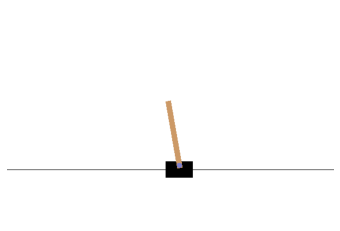

In [0]:
# Movimenti random

# Random Policy

state = env.reset() # si inizalizza il cart
img = plt.imshow(env.render(mode='rgb_array'))
done = False
i = 0
while not done:
    action = env.action_space.sample()  #come azioni si prende un campionamento casuale dello spazio delle azioni possibili
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action) #si applica l'azione e si ottiene il nuovo stato e il reward
    i = i + 1
env.close()
print('runs for: %i steps' %(i))

In [0]:
# giriamo 150 episodi e per oguno calcoliamo il reward e grafichiamo per vedere se ci sono trend 
# che indichino un qualche tipo di apprendimento ... (ovviamente non ci aspettiamo nulla)
episodes = 150
results = []  


for episode in range(episodes):
    state = env.reset()
    done = False 
    total = 0
    while not done:
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action) 
        total += reward 
    results.append(total)
    plot_results(results,title='Random Strategy')
    env.close()

KeyboardInterrupt: ignored

### Algoritmo Basilare

Ora provimo ad implementare un algoritmo basato su regole di buon senso rispetto al problema: per esempio se l'asta si inclina verso destra ci muoviamo a destra se si inclina verso sininsta ci muoviamo a sinistra 

In [0]:
env = gym.make("CartPole-v0")  # Create the environment
env.seed(seed)

# Simple Policy
def simple_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
done = False
i = 0
while not done:
    action = simple_policy(state)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action) 
    i = i + 1   
env.close()
print('run for: %i steps' %(i))

In [0]:
# giriamo 150 episodi e per oguno calcoliamo il reward e grafichiamo per vedere se ci sono trendo
episodes = 150
results = []  

for episode in range(episodes):
    state = env.reset()
    done = False 
    total = 0
    while not done:
        action = simple_policy(state)
        state, reward, done, _ = env.step(action) 
        total += reward 
    results.append(total)
    plot_results(results,title='Simple Strategy')
    env.close()

### Actor Critic Method

Algoritmo classico di RL di tipo Policy Gradient. In questo tipo di algoritmi si cerca direttamente di ottimizzare l'agente rispetto al policy space, modellando con un DNN le probabilità associate ad ogni azione da raccomandare.

Nell'agoritmo Actor-Critic (AC), l'agente è costituito da due entità separate: 
1. un attore (**actor**) che fornisce una rappresentazione della policy: assegnare un set di probabilità ad ogni azione possibile
2. un critico (**critic**) che non è altro che una value function, cioè una funzione dello stato che stima la somma di tutti i rewards che ci si aspetta ricevere nel futuro

Il critico apprende quanto bene l'attore (la policy) stà performando e sfrutta questa informazione per migliorare la policy stessa. Il miglioramento è ottenuto tramite Gradient Policy, cioè aggiornando la policy (l'attore) in modo da massimizzarne le stime della value function del critico, in parole diverse l'agente è addestrato in modo che le azioni raccomandate dall'attore massimizzano i reward futuri stimati dal critico.

## Implementazione della rete neurale

Costruiamo una semplice rete che apprende due funzioni:

1. Actor: prende in input lo state e ritorna un volare di probabilità per ogni azione dell'action space 
2. Critic: prende in input lo state e ritorna la stima del reward totale (scontato) atteso nel futuro 

Si può fare con due reti separate, ma visto che l'input è lo stesso nell'implementazione usaremo per comodità e compattezza un layer iniziale shared 


In [0]:
env = gym.make("CartPole-v0")  # Create the environment
env.seed(seed)

# Modello Actor-Critic 
num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.n
num_hidden = 128

inputs = layers.Input(shape=(num_inputs,))
common = layers.Dense(num_hidden, activation="relu")(inputs)
action = layers.Dense(num_actions, activation="softmax")(common)
critic = layers.Dense(1)(common)

model = keras.Model(inputs=inputs, outputs=[action, critic])

## Training

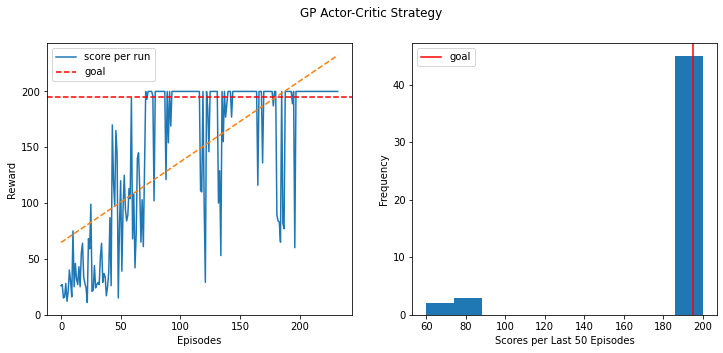

Solved at episode 233!
running reward: 1.30 at episode 0
running reward: 12.61 at episode 10
running reward: 22.92 at episode 20
running reward: 29.49 at episode 30
running reward: 31.57 at episode 40
running reward: 59.93 at episode 50
running reward: 77.11 at episode 60
running reward: 85.68 at episode 70
running reward: 126.73 at episode 80
running reward: 150.26 at episode 90
running reward: 169.19 at episode 100
running reward: 181.55 at episode 110
running reward: 176.03 at episode 120
running reward: 177.75 at episode 130
running reward: 172.09 at episode 140
running reward: 182.48 at episode 150
running reward: 189.51 at episode 160
running reward: 187.43 at episode 170
running reward: 191.89 at episode 180
running reward: 168.67 at episode 190
running reward: 175.14 at episode 200
running reward: 185.11 at episode 210
running reward: 191.09 at episode 220
running reward: 194.66 at episode 230
Solved at episode 232!


In [0]:
# optmizer e Loss
optimizer = keras.optimizers.Adam(learning_rate=0.01)
huber_loss = keras.losses.Huber() #una approssimazione intermedia tra MAE e MSE

# Parametri
gamma = 0.99  # Discount factor for past rewards
max_steps_per_episode = 10000
eps = np.finfo(np.float32).eps.item() # numero più piccolo per cui 1.0 + eps != 1.0

# container utili
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0

results = []
results_rr = []

while True:  # Run until solved
    state = env.reset()  #inzializza l'environment 
    episode_reward = 0

    with tf.GradientTape() as tape:
        for timestep in range(1, max_steps_per_episode):

            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0) #aggiunge una dimensione (4) -> (1,4) per tf/keras

            # dato lo stato la rete predice le probabilità delle azioni e stima i futuri rewards 
            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0, 0])

            # calcola la nuova action sulla base delle probabilità
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            # applica la nuova azione
            state, reward, done, _ = env.step(action)
            rewards_history.append(reward)
            episode_reward += reward

            if done:
                break


        # aggiorna il running reward 
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

        # calcolo valore atteso per il reward (i.e. le label del critic)
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with gamma
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        # Normalizzazione
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.tolist()

        # Calcolo delle loss per l'attore e per il critico 
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
    
            # per ogni valore nell'history il critico aveva stimato di avere in futuro un total reward pari a "value"
            # noi abbiamo intrapreso una data azione con log(prob) = log_prob e abbiamo ricevuto il reward pari a "ret"
           
            # dobbiamo aggiornare l'attore in modo che predica con maggiore probabilità un'azione che porti a più alti 
            # reward rispetto alle stime del critico 

            diff = ret - value
            actor_losses.append(-log_prob * diff)  # actor loss

            # dobbiamo aggornare il critico in modo che predica una migliore stima dei total reward futuri
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Clear the loss and reward history
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

    # salva dettagli per monitorare il tutto + printout
    episode_count += 1
    results_rr.append(running_reward)
    results.append(episode_reward)
    plot_results(results,title='GP Actor-Critic Strategy')
    
    if running_reward > 195:  # Condizione per cui la task è considerata risolta
        print("Solved at episode {}!".format(episode_count))
        break



#printout dei risultati
for episodio in range(episode_count):
    if episodio % 10 == 0:
        template = "running reward: {:.2f} at episode {}"
        print(template.format(results_rr[episodio], episodio))

    if results_rr[episodio] > 195:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episodio))
        break

run for: 200 steps


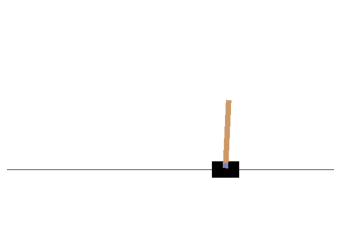

In [0]:
# test della rete addestrata

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
done = False
i = 0
while not done:
    state = tf.convert_to_tensor(state)
    state = tf.expand_dims(state, 0)
    action_probs, critic_value = model(state)
    action = np.random.choice(num_actions, p=np.squeeze(action_probs))
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action) 
    i = i + 1   
env.close()
print('run for: %i steps' %(i))

# Deep Q Networks


I DQN introdotte da Google nel 2013 fanno parte della classe di metodi di RL cosidetti di *value function based policies*. In questo tipo di metodi l'azione viene appresa rispetto ad un dato stato in base ad un cosidetto Q-value: un reward pesato basato su il massimo reward atteso nel futuro. Il task rispetto a cui viene addestrato il Q-agent è quella di raccomandare azioni che massimizzano il reward potenziale futuro. 
Nei DQN la Q-function è approssimata con un DNN.

Elementi:

$Q(s,a)$: Q-function, funzione dello stato *s* e azione *a*, approssimata in una DQN da una rete neurale profonda.

Loss: $L = \frac{1}{2}(r + \gamma \underset{{a'}}\max \hat{Q}(s,a') - Q(s,a) )^2$

in cui:

*   i primi due termini rappresentano il target
*   il secondo termine la predizione
*   $\gamma$ è il discount factor

L'agente esegue l'azione *a* e osserva un reward *r* e un nuovo stato *s'*. Sulla base di questo calcola il massimo target Q e lo sconta in modo che i reward futuri abbiano sempre meno peso rispetto ai reward immediati (in modo simile al rate di interesse su un prestito). A questo punto il reward corrente viene sommato al reward futuro scontato per costruire il target che viene confrontato con la predizione corrente tramite una MSE-like.

Due caratteristiche fondamentali dell'algoritmo DQN sono i concetti di *memory* e *replay*:

*   *memory*: uno dei problemi principali per una DQN è legato al fatto che la DNN usata dall'algoritmo tende a dimenticare velocemente l'esperienza pregressa mano a mano che sovrascrive (aggiorna i pesi) con nuova esperienza. Per risolvere il problema viene mantenuta una lista delle esperienze e osservazioni precedenti che viene utilizzata per ri-addestrare il modello con tutta l'esperienza passata. Questa lista viene chiamata memory e memorizza in una lista lo stato, l'azione, il reward e lo stato successivo ad ogni step del processo analizzato.
*   *replay*: è la parte del NN che addestra la rete con lesperienza salvata in memory.  In pratica campiona un batch di esperienze da memory (minibatch), e per tali azioni stima il discounted future reward.

L'azione raccomandata dall'agente iniziamente è per una certa percentuale (detta epsilon o exploration rate) di tipo random. Questo garantisce inzialmente all'agente la possibilità di esplorare tutte le possibilità di azione prima di essere in grado di riconoscerene i pattern. Mano a mano che il training avanza il rate di esplorazione random viene ridotto, e l'agente sostanzialmente predice il reward basansosi sullo stato corrente e raccomanda l'azione che produce il massimo reward. 

### MountainCar-v0: con policy random o policy elementare

In [0]:
seed = 12345

env = gym.make("MountainCar-v0")  # Create the environment
env.seed(seed)

[12345]

run for: 171 steps


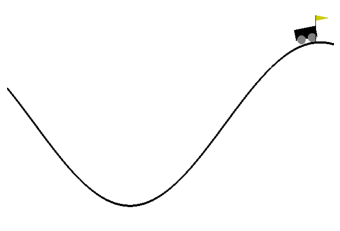

In [0]:
# Simple Policy (i.e. agire nella direzione del moto)
def simple_policy(obs, i):
    vel = obs[1]
    pos = obs[0]+0.5 #minimum in 0
# al primo step (v=0) accelera in direzione della discesa   
    if i == 0:
        return 0 if pos > 0 else 2
 # ai successivi accelera nella direzione in cui ci si sta muovendo     
    return 2 if vel > 0 else 0


# seleziona simple or random policy
random_policy = False

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
done = False
i = 0
while not done:
    if random_policy:
        action = env.action_space.sample()
    else:
        action = simple_policy(state, i)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action) 
    i = i + 1   
env.close()
print('run for: %i steps' %(i))

In [0]:
# DQN algorithm
# Dueling-DQN (DDQN) Implementation (più stabile rispetto a plain DQN)
# https://arxiv.org/pdf/1511.06581.pdf

# ci sono due reti neurali separate invece che una sola che fa entrambe le cose:
# il Q-network che seleziona l'azione, e il target Q-network che valuta l'azione

class DQN:
    def __init__(self, env):
        self.env=env
        self.gamma=0.99 #discount rate
        self.epsilon = 1
        self.epsilon_decay = 0.05
        self.epsilon_min=0.01
        self.episodes=300 #numero di episodi
        self.iterations=201 #200 è il limite imposto dall'environment
        self.batch_size=32 #batch size quando si campiona memory
        self.memory=deque(maxlen=20000)
        
        self.model_train=self.model()
        self.model_target=self.model()
        self.model_target.set_weights(self.model_train.get_weights())

    def model(self): #modello rete neurale
        state_shape = self.env.observation_space.shape
        model = keras.models.Sequential()
        model.add(layers.Dense(24, activation='relu', input_shape=state_shape))
        model.add(layers.Dense(48, activation='relu'))
        model.add(layers.Dense(self.env.action_space.n,activation='linear'))
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.001))
        return model

    def act(self,state): #calcola l'azione
        self.epsilon = max(self.epsilon_min, self.epsilon)

        if np.random.rand(1) < self.epsilon: #parte random
            action = np.random.randint(0, 3)
        else: #parte non random
            action = np.argmax(self.model_train.predict(state)[0])

        return action


    def replay(self): #replay 
        if len(self.memory) < self.batch_size:
            return

        samples = random.sample(self.memory, self.batch_size)

        states = []
        newStates=[]
        for sample in samples:
            state, action, reward, new_state, done = sample
            states.append(state)
            newStates.append(new_state)

        newArray = np.array(states)
        states = newArray.reshape(self.batch_size, 2)

        newArray2 = np.array(newStates)
        newStates = newArray2.reshape(self.batch_size, 2)

        targets = self.model_train.predict(states)
        new_state_targets=self.model_target.predict(newStates)

        i=0
        for sample in samples:
            state, action, reward, new_state, done = sample
            target = targets[i]
            if done:
                target[action] = reward
            else:
                Q_future = max(new_state_targets[i])
                target[action] = reward + Q_future * self.gamma
            i+=1

        self.model_train.fit(states, targets, epochs=1, verbose=0)


    def train(self, currentState, eps): #training
        rewardSum = 0
        max_position=-99

        for i in range(self.iterations):
            bestAction = self.act(currentState)

            new_state, reward, done, _ = env.step(bestAction)

            new_state = new_state.reshape(1, 2)

            # Tiene traccia della massima posizione della macchina (il goal è arrivare a 0.5)
            if new_state[0][0] > max_position:
                max_position = new_state[0][0]

            # Nel caso di succeso big boost al reward (10 invece che zero)
            if new_state[0][0] >= 0.5:
                reward += 10

            # Modifica del reward per tenere conto che fino a quando la macchina non raggiung 0.5 
            # non riceve nessun reward (reward è -1 per ogni step e +10 quando arriva in cima)
            # diamo un reward proporzionale a quanto è risucita a salire in alto la macchina
            # NB altezza della macchina = np.sin(3 * posizione)*.45+.55

            if new_state[0][0] >= -0.4:
               reward += (np.sin(3 * new_state[0][0])*.45+.55+0.45)**2

            # Memorize
            self.memory.append([currentState, bestAction, reward, new_state, done])

            # Replay
            self.replay()

            rewardSum += reward

            currentState = new_state

            if done:
                break

        if i >= 199:
            print("Failed to finish task in epsoide {}".format(eps))
        else:
            print("Success in epsoide {}, used {} iterations!".format(eps, i))
            self.model_train.save('./bestDQNnet.h5')

        #Sync
        self.model_target.set_weights(self.model_train.get_weights())

        print("now epsilon is {}, the reward is {} maxPosition is {}".format(max(self.epsilon_min, self.epsilon), rewardSum,max_position))
        self.epsilon -= self.epsilon_decay

    def start(self):
        for eps in range(self.episodes):
            currentState=env.reset().reshape(1,2)
            self.train(currentState, eps)

In [0]:
env = gym.make('MountainCar-v0')
dqn=DQN(env=env)
dqn.start()

Failed to finish task in epsoide 0
now epsilon is 1, the reward is -200.0 maxPosition is -0.43977217571148175
Failed to finish task in epsoide 1
now epsilon is 0.95, the reward is -195.49894453410403 maxPosition is -0.377860606193882
Failed to finish task in epsoide 2
now epsilon is 0.8999999999999999, the reward is -200.0 maxPosition is -0.4000804064020402
Failed to finish task in epsoide 3
now epsilon is 0.8499999999999999, the reward is -185.42807652056428 maxPosition is -0.32309004475544645
Failed to finish task in epsoide 4
now epsilon is 0.7999999999999998, the reward is -200.0 maxPosition is -0.41793618647659847
Failed to finish task in epsoide 5
now epsilon is 0.7499999999999998, the reward is -194.20387529893944 maxPosition is -0.3459367974376714
Failed to finish task in epsoide 6
now epsilon is 0.6999999999999997, the reward is -195.0400248300165 maxPosition is -0.3620523877690259
Failed to finish task in epsoide 7
now epsilon is 0.6499999999999997, the reward is -186.5605040

run for: 157 steps


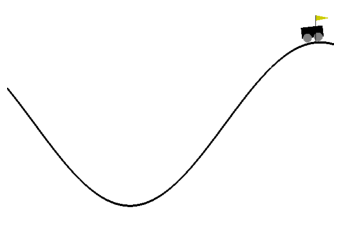

In [0]:
# Test
env = gym.make('MountainCar-v0')
model=keras.models.load_model('bestDQNnet.h5')

state = env.reset().reshape(1, 2)
img = plt.imshow(env.render(mode='rgb_array'))
done = False
i = 0
while not done:
    Q = model.predict(state)
    action = np.argmax(Q[0])
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action) 
    state = np.reshape(state, (1,2))
    i = i + 1   
print('run for: %i steps' %(i))

# Compiti

Sono opzionali ... 

1.   provare a risolvere i due problemi scambando gli algoritmi: PG per la MountainCar e DQN per il CartPole
2.   provare ad implementare un porblema con spazio delle azioni continuo (per esempio *CartPole_V1*)




##DQN per il CartPole (pendolo inverso)

In [0]:
# DQN algorithm
# Dueling-DQN (DDQN) Implementation (più stabile rispetto a plain DQN)
# https://arxiv.org/pdf/1511.06581.pdf

# ci sono due reti neurali separate invece che una sola che fa entrambe le cose:
# il Q-network che seleziona l'azione, e il target Q-network che valuta l'azione

class DQN:
    def __init__(self, env):
        self.env=env
        self.gamma=0.99 #discount rate
        self.epsilon = 1
        self.epsilon_decay = 0.05
        self.epsilon_min=0.01
        self.episodes=300 #numero di episodi
        self.iterations=201 #200 è il limite imposto dall'environment
        self.batch_size=32 #batch size quando si campiona memory
        self.memory=deque(maxlen=20000)
        
        self.model_train=self.model()
        self.model_target=self.model()
        self.model_target.set_weights(self.model_train.get_weights())

    def model(self): #modello rete neurale
        state_shape = self.env.observation_space.shape
        model = keras.models.Sequential()
        model.add(layers.Dense(24, activation='relu', input_shape=state_shape))
        model.add(layers.Dense(48, activation='relu'))
        model.add(layers.Dense(self.env.action_space.n,activation='linear'))
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.001))
        return model

    def act(self, state): #calcola l'azione
        self.epsilon = max(self.epsilon_min, self.epsilon)

        if np.random.rand(1) < self.epsilon: #parte random
            action = np.random.randint(0, 2)
        else: #parte non random
            action = np.argmax(self.model_train.predict(state)[0])

        return action


    def replay(self): #replay 
        if len(self.memory) < self.batch_size:
            return

        samples = random.sample(self.memory, self.batch_size)

        states = []
        newStates=[]
        for sample in samples:
            state, action, reward, new_state, done = sample
            states.append(state)
            newStates.append(new_state)

        newArray = np.array(states)
        states = newArray.reshape(self.batch_size, 4)

        newArray2 = np.array(newStates)
        newStates = newArray2.reshape(self.batch_size, 4)

        targets = self.model_train.predict(states)
        new_state_targets=self.model_target.predict(newStates)

        i=0
        for sample in samples:
            state, action, reward, new_state, done = sample
            target = targets[i]
            if done:
                target[action] = reward
            else:
                Q_future = max(new_state_targets[i])
                target[action] = reward + Q_future * self.gamma
            i+=1

        self.model_train.fit(states, targets, epochs=1, verbose=0)


    def train(self, currentState, eps): #training
        rewardSum = 0

        for i in range(self.iterations):
            bestAction = self.act(currentState)

            new_state, reward, done, _ = env.step(bestAction)

            new_state = new_state.reshape(1, 4)

            # Memorize
            self.memory.append([currentState, bestAction, reward, new_state, done])

            # Replay
            self.replay()

            rewardSum += reward

            currentState = new_state

            if done:
                break

        if i >= 199:           
            print("Success in epsoide {}, used {} iterations!".format(eps, i))
            self.model_train.save('./bestDQNnet.h5')

        #Sync
        self.model_target.set_weights(self.model_train.get_weights())

        print("now epsilon is {}, the reward is {}".format(max(self.epsilon_min, self.epsilon), rewardSum))
        self.epsilon -= self.epsilon_decay

    def start(self):
        for eps in range(self.episodes):
            currentState=env.reset().reshape(1,4)
            self.train(currentState, eps)

In [0]:
env = gym.make('CartPole-v0')
dqn=DQN(env=env)
dqn.start()

now epsilon is 1, the reward is 11.0
now epsilon is 0.95, the reward is 21.0
now epsilon is 0.8999999999999999, the reward is 13.0
now epsilon is 0.8499999999999999, the reward is 22.0
now epsilon is 0.7999999999999998, the reward is 26.0
now epsilon is 0.7499999999999998, the reward is 14.0
now epsilon is 0.6999999999999997, the reward is 13.0
now epsilon is 0.6499999999999997, the reward is 13.0
now epsilon is 0.5999999999999996, the reward is 14.0
now epsilon is 0.5499999999999996, the reward is 13.0
now epsilon is 0.4999999999999996, the reward is 13.0
now epsilon is 0.4499999999999996, the reward is 11.0
now epsilon is 0.39999999999999963, the reward is 12.0
now epsilon is 0.34999999999999964, the reward is 13.0
now epsilon is 0.29999999999999966, the reward is 9.0
now epsilon is 0.24999999999999967, the reward is 12.0
now epsilon is 0.19999999999999968, the reward is 11.0
now epsilon is 0.1499999999999997, the reward is 11.0
now epsilon is 0.09999999999999969, the reward is 11.0


L'algoritmo è andato a convergenza.

## Continous Cart Pole con Actor-Critic

### Definizione classe `ContinuousCartPoleEnv`

In [0]:
"""
Classic cart-pole system implemented by Rich Sutton et al.
Copied from http://incompleteideas.net/sutton/book/code/pole.c
permalink: https://perma.cc/C9ZM-652R
Continuous version by Ian Danforth
"""

from gym import spaces, logger
from gym.utils import seeding

class ContinuousCartPoleEnv(gym.Env):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 50
    }

    def __init__(self):
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = (self.masspole + self.masscart)
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = (self.masspole * self.length)
        self.force_mag = 30.0
        self.tau = 0.02  # seconds between state updates
        self.min_action = -1.0
        self.max_action = 1.0

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4

        # Angle limit set to 2 * theta_threshold_radians so failing observation
        # is still within bounds
        high = np.array([
            self.x_threshold * 2,
            np.finfo(np.float32).max,
            self.theta_threshold_radians * 2,
            np.finfo(np.float32).max])

        self.action_space = spaces.Box(
            low=self.min_action,
            high=self.max_action,
            shape=(1,)
        )
        self.observation_space = spaces.Box(-high, high)

        self.seed()
        self.viewer = None
        self.state = None

        self.steps_beyond_done = None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def stepPhysics(self, force):
        x, x_dot, theta, theta_dot = self.state
        costheta = math.cos(theta)
        sintheta = math.sin(theta)
        temp = (force + self.polemass_length * theta_dot * theta_dot * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / \
            (self.length * (4.0/3.0 - self.masspole * costheta * costheta / self.total_mass))
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass
        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc
        return (x, x_dot, theta, theta_dot)

    def step(self, action):
        assert self.action_space.contains(action), \
            "%r (%s) invalid" % (action, type(action))
        # Cast action to float to strip np trappings
        force = self.force_mag * float(action)
        self.state = self.stepPhysics(force)
        x, x_dot, theta, theta_dot = self.state
        done = x < -self.x_threshold \
            or x > self.x_threshold \
            or theta < -self.theta_threshold_radians \
            or theta > self.theta_threshold_radians
        done = bool(done)

        if not done:
            reward = 1.0
        elif self.steps_beyond_done is None:
            # Pole just fell!
            self.steps_beyond_done = 0
            reward = 1.0
        else:
            if self.steps_beyond_done == 0:
                logger.warn("""
You are calling 'step()' even though this environment has already returned
done = True. You should always call 'reset()' once you receive 'done = True'
Any further steps are undefined behavior.
                """)
            self.steps_beyond_done += 1
            reward = 0.0

        return np.array(self.state), reward, done, {}

    def reset(self):
        self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
        self.steps_beyond_done = None
        return np.array(self.state)

    def render(self, mode='human'):
        screen_width = 600
        screen_height = 400

        world_width = self.x_threshold * 2
        scale = screen_width /world_width
        carty = 100  # TOP OF CART
        polewidth = 10.0
        polelen = scale * 1.0
        cartwidth = 50.0
        cartheight = 30.0

        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(screen_width, screen_height)
            l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
            axleoffset = cartheight / 4.0
            cart = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.carttrans = rendering.Transform()
            cart.add_attr(self.carttrans)
            self.viewer.add_geom(cart)
            l, r, t, b = -polewidth / 2, polewidth / 2, polelen-polewidth / 2, -polewidth / 2
            pole = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            pole.set_color(.8, .6, .4)
            self.poletrans = rendering.Transform(translation=(0, axleoffset))
            pole.add_attr(self.poletrans)
            pole.add_attr(self.carttrans)
            self.viewer.add_geom(pole)
            self.axle = rendering.make_circle(polewidth / 2)
            self.axle.add_attr(self.poletrans)
            self.axle.add_attr(self.carttrans)
            self.axle.set_color(.5, .5, .8)
            self.viewer.add_geom(self.axle)
            self.track = rendering.Line((0, carty), (screen_width, carty))
            self.track.set_color(0, 0, 0)
            self.viewer.add_geom(self.track)

        if self.state is None:
            return None

        x = self.state
        cartx = x[0] * scale + screen_width / 2.0  # MIDDLE OF CART
        self.carttrans.set_translation(cartx, carty)
        self.poletrans.set_rotation(-x[2])

        return self.viewer.render(return_rgb_array=(mode == 'rgb_array'))

    def close(self):
        if self.viewer:
            self.viewer.close()

### Reti

In [9]:
import math
env = ContinuousCartPoleEnv()  # Create the environment
env.seed(seed)

# Modello Actor-Critic 
num_inputs = env.observation_space.shape[0]
num_hidden = 32

inputs = layers.Input(shape=(num_inputs,))
x = layers.Dense(num_hidden, activation="relu")(inputs)
x = layers.Dense(num_hidden, activation="relu")(x)
x = layers.Dense(num_hidden, activation="relu")(x)

y = layers.Dense(num_hidden, activation="relu")(inputs)
y = layers.Dense(num_hidden, activation="relu")(y)

critic = layers.Dense(1)(x)

action_mean = layers.Dense(1, activation="tanh")(y)
action_std = layers.Dense(1, activation="softplus")(y)

model = keras.Model(inputs=inputs, outputs=[action_mean, action_std, critic])

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
# optmizer e Loss
optimizer = keras.optimizers.Adam(learning_rate=0.01) # non è altino?!
huber_loss = keras.losses.Huber() #una approssimazione intermedia tra MAE e MSE

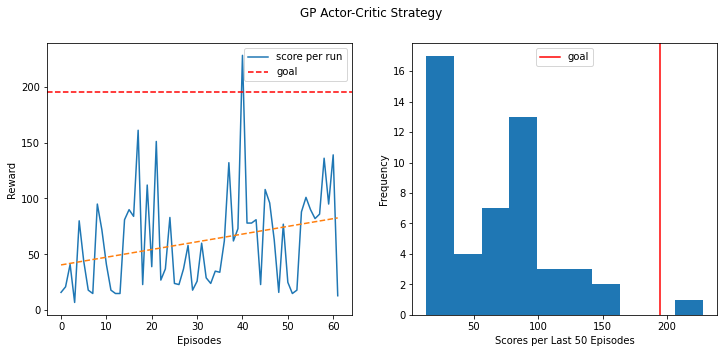

 [[1]] [[-0.741066694]]

In [0]:
# Parametri
gamma = 0.99  # Discount factor for past rewards
max_steps_per_episode = 10000
eps = np.finfo(np.float32).eps.item() # numero più piccolo per cui 1.0 + eps != 1.0

# container utili
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0

results = []
results_rr = []

while True:  # Run until solved
    state = env.reset()  #inzializza l'environment 
    episode_reward = 0

    with tf.GradientTape() as tape:
        for timestep in range(1, max_steps_per_episode):

            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0) #aggiunge una dimensione (4) -> (1,4) per tf/keras

            # dato lo stato la rete predice le probabilità delle azioni e stima i futuri rewards 
            action_mean, action_std, critic_value = model(state)
            action_std = tf.clip_by_value(action_std, 0.01, 1)

            tf.print("\r", action_std, action_mean, end="")

            critic_value_history.append(critic_value[0, 0])

            # calcola la nuova action sulla base delle probabilità
            # estrae l'azione con media e std date dall'actor
            action = tf.random.normal((1,), mean=action_mean, stddev=action_std)
            action = tf.clip_by_value(action, -1, 1)
            action_pdf_log = -tf.math.log(action_std) - tf.math.square(action-action_mean)/(2*tf.math.square(action_std))
            action_probs_history.append(action_pdf_log)

            # applica la nuova azione
            temp = env.step(action[0])
            state, reward, done, _ = temp

            rewards_history.append(reward)
            episode_reward += reward

            if done:
                break

        # aggiorna il running reward 
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward
        tf.debugging.check_numerics(running_reward, "running_reward")
        # calcolo valore atteso per il reward (i.e. le label del critic)
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with gamma
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)
            tf.debugging.check_numerics(discounted_sum, "discounted_sum")

        # Normalizzazione
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)

        returns = returns.tolist()

        # Calcolo delle loss per l'attore e per il critico 
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
    
            # per ogni valore nell'history il critico aveva stimato di avere in futuro un total reward pari a "value"
            # noi abbiamo intrapreso una data azione con log(prob) = log_prob e abbiamo ricevuto il reward pari a "ret"
           
            # dobbiamo aggiornare l'attore in modo che predica con maggiore probabilità un'azione che porti a più alti 
            # reward rispetto alle stime del critico 

            diff = ret - value

            actor_losses.append(-log_prob * diff)  # actor loss

            critic_loss = huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))

            # dobbiamo aggornare il critico in modo che predica una migliore stima dei total reward futuri
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Clear the loss and reward history
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

    # salva dettagli per monitorare il tutto + printout
    episode_count += 1
    results_rr.append(running_reward)
    results.append(episode_reward)
    plot_results(results,title='GP Actor-Critic Strategy')
    
    if running_reward > 195:  # Condizione per cui la task è considerata risolta
        print("Solved at episode {}!".format(episode_count))
        break

#printout dei risultati
for episodio in range(episode_count):
    if episodio % 10 == 0:
        template = "running reward: {:.2f} at episode {}"
        print(template.format(results_rr[episodio], episodio))

    if results_rr[episodio] > 195:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episodio))
        break